In [ ]:
!pip install --upgrade matplotlib numpy

In [2]:
from DataProcessing import read_data, make_graphs
from models import GNN
from training import test, load_checkpoint
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data

Load model

In [48]:
model = GNN(3, 7, 3)
lossFunc = torch.nn.L1Loss(reduction='sum')

checkpoint_path = 'checkpoints/mpl_out_epoch_30.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\cirob\AppData\Local\Temp\ipykernel_24464\2593035466.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


GNN(
  (node_encoder): mlp(
    (mlp): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=False)
      (4): PReLU(num_parameters=1)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=False)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (edge_encoder): mlp(
    (mlp): Sequential(
      (0): Linear(in_features=7, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=False)
      (4): PReLU(num_parameters=1)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=False)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=128, out_features=128, bias=True)
    )
 

Loss vs epoch plot

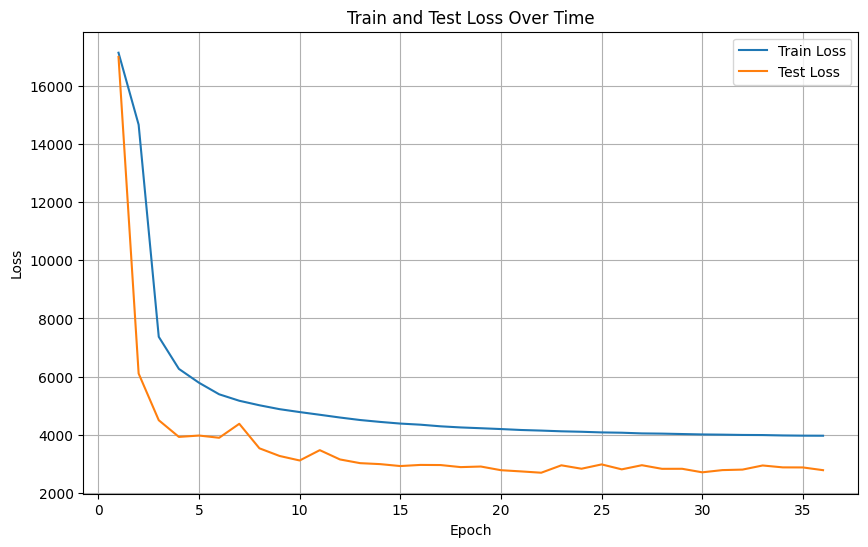

In [19]:
# Initialize lists to store the data
epochs = []
train_losses = []
test_losses = []

# Read the data from the file
with open('training_log.txt', 'r') as file:
    lines = file.readlines()[:72]  # Read lines 61 to 120 (0-based index)

    for line in lines:
        if line.startswith('Epoch:'):
            parts = line.split(',')
            epoch = int(parts[0].split(':')[1].strip())
            train_loss = float(parts[1].split(':')[1].strip())
            test_loss = float(parts[2].split(':')[1].strip())
            
            epochs.append(epoch)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Tests on different systems
1) Test the model with a 1600 water molecules system (it was trained on 216 molecules systems). It should achieve similar performance.

In [36]:
charges = [None, -0.82, 0.41]
LJ_params = [None, (0.155, 3.165), (0, 0)]
data = read_data(['data/big_water.lammpstrj'])
test_graphs = make_graphs(data, charges, LJ_params, cutoff=3.4)
test_loader = DataLoader(test_graphs, batch_size=16)

test_loss = test(model, test_loader, lossFunc)
np.array(test_loss) / 4800 * 648

array([3581.92916016, 1174.26269531, 1215.68103809, 1191.98545313])

In [21]:
tot = 0
for graph in test_graphs:
    tot += torch.sum(torch.abs(graph.y))
tot / 4800 / len(test_graphs)

tensor(23.3039)

2) Test on argon system (varying cutoff radius). The performance depends on how well the model learned O-O Lennard-Jones interaction during training.

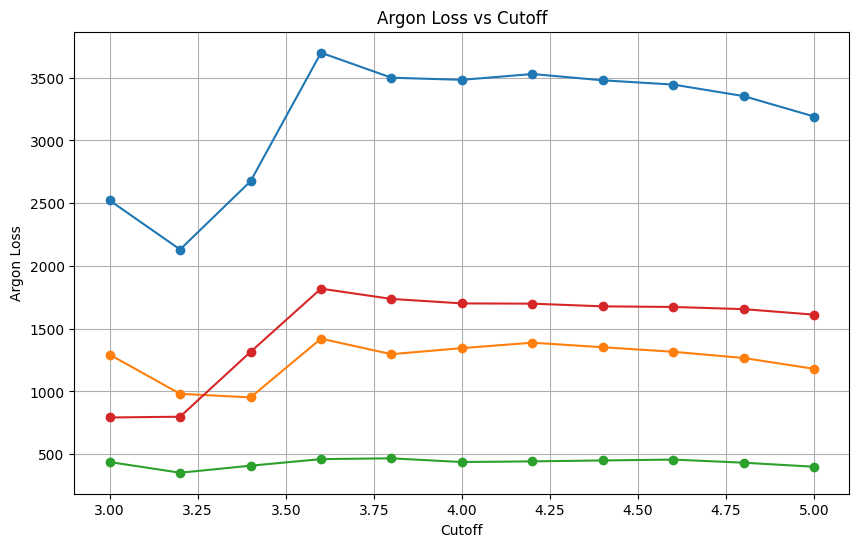

In [35]:
charges = [None, 0]
LJ_params = [None, (0.2378, 3.405)]
data = read_data(['data/argon.lammpstrj'], molecular=False)
cutoffs = np.linspace(3, 5, 11)
argon_losses = []
for cutoff in cutoffs:
    argon_graphs = make_graphs(data, charges, LJ_params, cutoff=cutoff)
    argon_loader = DataLoader(argon_graphs, batch_size=32)
    argon_loss = test(model, argon_loader, lossFunc)
    argon_losses.append(argon_loss)

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, argon_losses, marker='o')
plt.xlabel('Cutoff')
plt.ylabel('Argon Loss')
plt.title('Argon Loss vs Cutoff')
plt.grid(True)
plt.show()

# Single potential tests
How much Physics did the model learn?  
Assesing how good it fits the single potentials is a good method to evaluate transferability.  
The tests are done creating graphs with two nodes at variyng distance. The particle parameters are similar to those in the training data.

In [38]:
def plot_potential(force_func, distances, nodes, ax=0):
    if force_func == bound:
        edge_type = torch.tensor([0,1,0], dtype=torch.float)
    else: edge_type = torch.tensor([1,0,0], dtype=torch.float)

    direction = torch.tensor([0,0,0], dtype=torch.float)
    direction[ax] = 1

    graphs = []
    for distance in distances:
        distance = torch.tensor([distance], dtype=torch.float)
        edge_attr1=torch.cat([edge_type, distance, direction])
        edge_attr2=torch.cat([edge_type, distance, -direction])
        graph = Data(x=torch.tensor(nodes, dtype=torch.float),
                    edge_index=torch.tensor([[0, 1], [1, 0]]),
                    edge_attr=torch.stack([edge_attr1, edge_attr2]))
        graphs.append(graph)

    data = DataLoader(graphs, batch_size=1)
    preds = []
    predsy = []
    predsz = []
    for graph in data:
        with torch.no_grad():
            out = model(graph)
        preds.append(out[0][ax].detach().numpy())
        predsy.append(out[0][ax-2].detach().numpy())
        predsz.append(out[0][ax-1].detach().numpy())
    
    if force_func == bound:
        gt = [force_func(d) for d in distances]
    elif force_func == Coul_force:
        gt = [force_func(d, nodes[0][0], nodes[1][0]) for d in distances]
    elif force_func == LJ_force:
        gt = [force_func(d, np.sqrt(nodes[0][1] * nodes[1][1]), np.sqrt(nodes[0][2] * nodes[1][2])) for d in distances]
    gty = [0 for _ in distances]
    gtz = [0 for _ in distances]

    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    axs[0].plot(distances, gt, label='Ground Truth', color='blue', linestyle='--')
    axs[0].plot(distances, preds, label='Predictions', color='blue', linestyle='-')
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Force X')
    axs[0].set_title('Ground Truth vs Predictions (X)')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(distances, gty, label='Ground Truth', color='green', linestyle='--')
    axs[1].plot(distances, predsy, label='Predictions', color='green', linestyle='-')
    axs[1].set_xlabel('Distance')
    axs[1].set_ylabel('Force Y')
    axs[1].set_title('Ground Truth vs Predictions (Y)')
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(distances, gtz, label='Ground Truth', color='purple', linestyle='--')
    axs[2].plot(distances, predsz, label='Predictions', color='purple', linestyle='-')
    axs[2].set_xlabel('Distance')
    axs[2].set_ylabel('Force Z')
    axs[2].set_title('Ground Truth vs Predictions (Z)')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()

In [23]:
# LJ potential
def LJ_force(r, epsilon, sigma):
    return 4 * epsilon * (12 * sigma**12 / r ** 13 - 6 * sigma**6 / r ** 7)

# Coulomb potential
def Coul_force(r, q1, q2, c=332.0637):
    return c * q1 * q2 / r ** 2

# harmonic bound
def bound(r, k=529.581, r0=1.012):
    return - 2 * k * (r - r0)

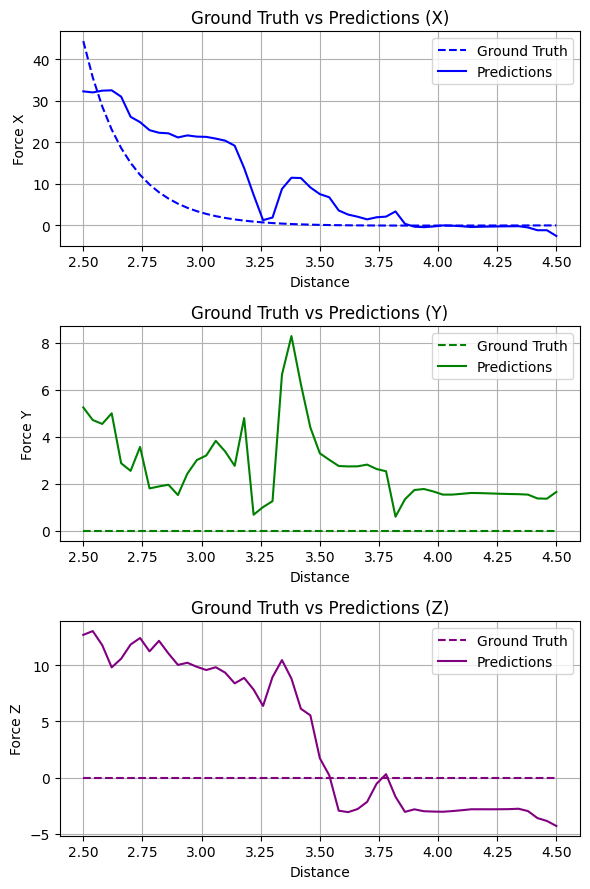

In [49]:
distances = np.linspace(2.5, 4.5, 51)
nodes = [[0, 0.155, 3.165], [0, 0.155, 3.165]]

plot_potential(LJ_force, distances, nodes)

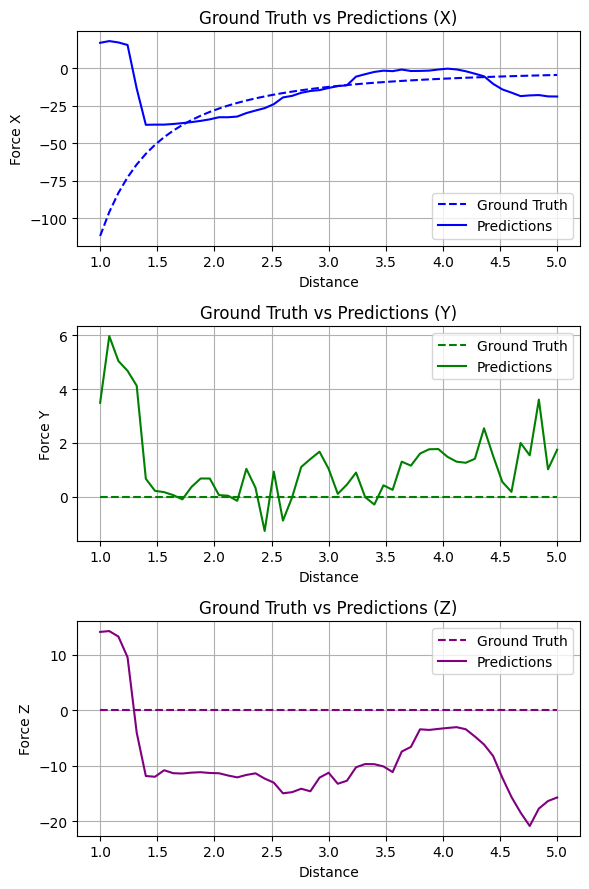

In [50]:
distances = torch.linspace(1, 5, 51)

plot_potential(Coul_force, distances, [[-0.82, 0.155, 3.165], [0.41, 0, 0]])


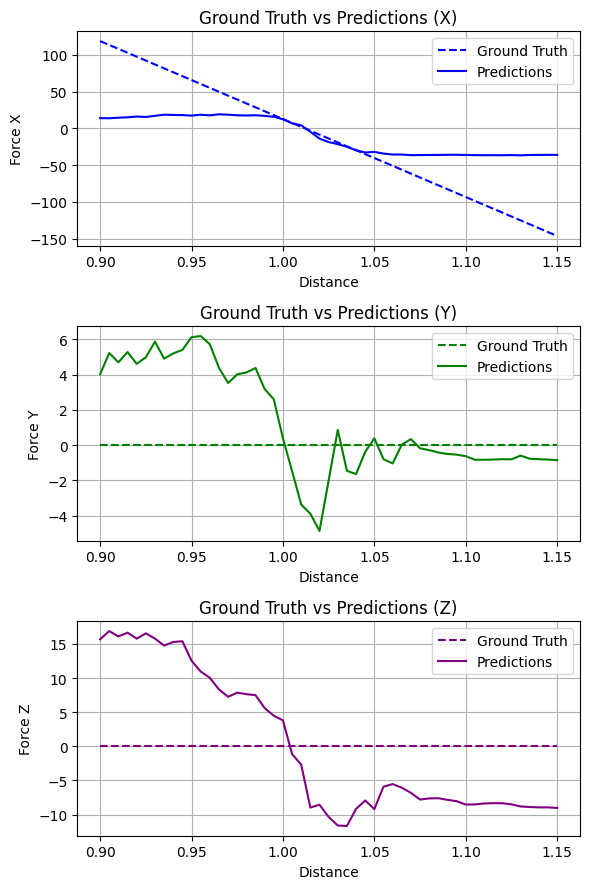

In [30]:
distances = np.linspace(0.9, 1.15, 51)
nodes = [[-0.82, 0.155, 3.165], [0.41, 0, 0]]

plot_potential(bound, distances, nodes)

Generalization is not good at all. But can the model at least be fine-tuned easily?  
These are the results after further training including both water and argon systems

In [51]:
checkpoint_path = 'checkpoints/argon_epoch_60.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\cirob\AppData\Local\Temp\ipykernel_24464\2910358422.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


GNN(
  (node_encoder): mlp(
    (mlp): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=False)
      (4): PReLU(num_parameters=1)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=False)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (edge_encoder): mlp(
    (mlp): Sequential(
      (0): Linear(in_features=7, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=False)
      (4): PReLU(num_parameters=1)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=False)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=128, out_features=128, bias=True)
    )
 

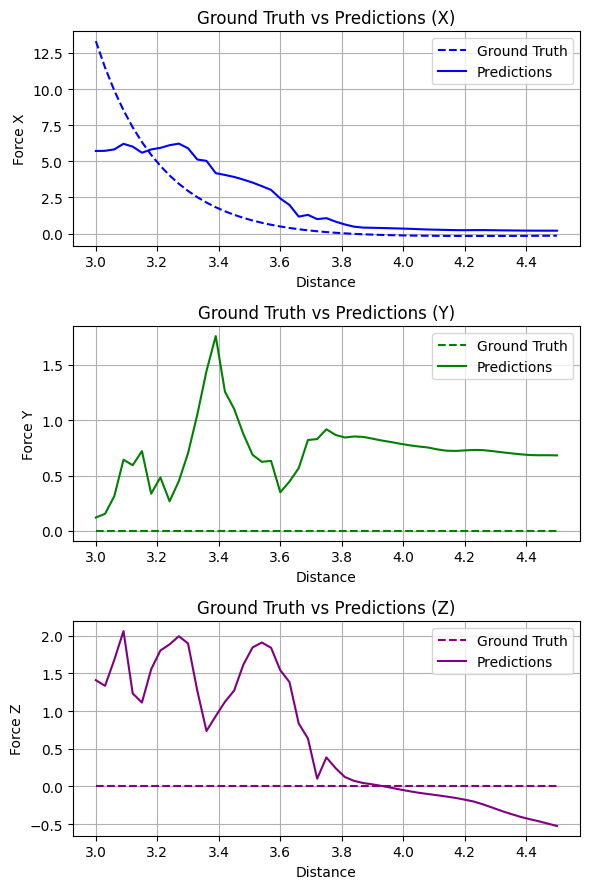

In [53]:
distances = np.linspace(3, 4.5, 51)
nodes = [[0, 0.2378, 3.405], [0, 0.2378, 3.405]]

plot_potential(LJ_force, distances, nodes, ax=0)

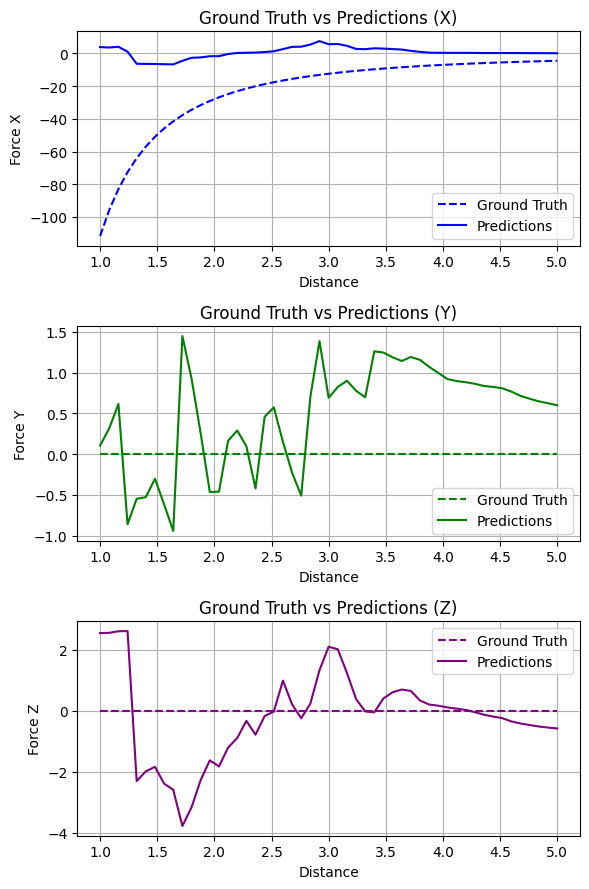

In [54]:
distances = torch.linspace(1, 5, 51)

plot_potential(Coul_force, distances, [[-0.82, 0.155, 3.165], [0.41, 0, 0]])

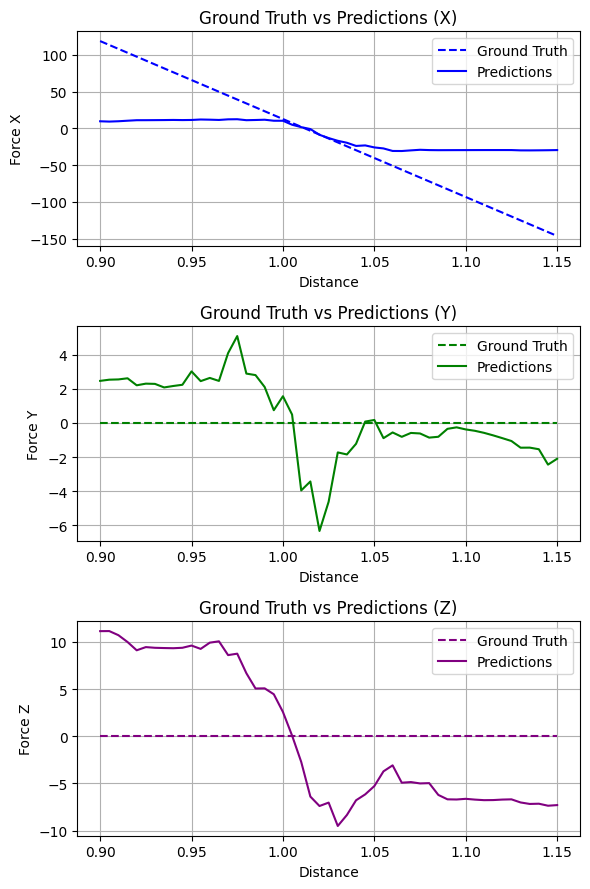

In [34]:
distances = np.linspace(0.9, 1.15, 51)
nodes = [[-0.82, 0.155, 3.165], [0.41, 0, 0]]

plot_potential(bound, distances, nodes)